In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import string
import tensorflow as tf

from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from itertools import chain
from pathlib import Path

from tensorflow.keras.layers import Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, concatenate, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2.4.1


In [2]:
nltk.download('punkt', download_dir='.')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Определим структуру данных**

In [3]:
!head train_data.txt

1 ::: Oscar et la dame rose (2009) ::: drama ::: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.
2 ::: Cupid (1997) ::: thriller ::: A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
3 ::: Young, Wild and Wonderful (1980) ::: adult ::: As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the s

**Сформируем тренировочный и тестовый датафреймы. Закодируем категориальный признак.**

In [4]:
ord_enc = OrdinalEncoder()

In [5]:
train_df = pd.read_csv('train_data.txt', sep=':::', engine='python', names=['ID', 'Title', 'Genre', 'Description'])
train_df.drop(train_df[train_df.Description.isnull()].index, inplace=True)
train_df['Genre_cat'] = ord_enc.fit_transform(train_df[['Genre']])
train_df.head()

,ID,Title,Genre,Description,Genre_cat
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8.0
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24.0
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1.0
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8.0
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8.0


In [6]:
test_df = pd.read_csv('test_data_solution.txt', sep=':::', engine='python', names=['ID', 'Title', 'Genre', 'Description'])
test_df.drop(test_df[test_df.Description.isnull()].index, inplace=True)
test_df['Genre_cat'] = ord_enc.fit_transform(test_df[['Genre']])
test_df.head()

,ID,Title,Genre,Description,Genre_cat
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",24.0
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",5.0
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,7.0
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",8.0
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,8.0


**Сформируем список стоп-слов**

In [7]:
# stop_words = nltk.corpus.stopwords.words('english')

# стоп-слова
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'shold',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
]

**Создадим функцию для токенизации**

In [8]:
def text_tokenizer(raw_text: str):
    tokenize_text = nltk.word_tokenize(raw_text)
    tokens = [i.lower() for i in tokenize_text if (i not in string.punctuation)]
    filtered_tokens = [i for i in tokens if (i not in stop_words)]
    return filtered_tokens

**Применим функцию к столбцу датафрейма, содержащему описания**

In [9]:
tokenized_descriptions_train = train_df.Description.apply(text_tokenizer)
tokenized_descriptions_test = test_df.Description.apply(text_tokenizer)

In [10]:
train_df['Tokenized_descriptions'] = tokenized_descriptions_train
train_df.head()

,ID,Title,Genre,Description,Genre_cat,Tokenized_descriptions
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8.0,"[listening, conversation, doctor, parents, 10-..."
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24.0,"[brother, sister, past, incestuous, relationsh..."
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1.0,"[bus, empties, students, field, trip, museum, ..."
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8.0,"[help, unemployed, father, make, ends, meet, e..."
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8.0,"[film, 's, title, refers, un-recovered, bodies..."


In [11]:
test_df['Tokenized_descriptions'] = tokenized_descriptions_test
test_df.head()

,ID,Title,Genre,Description,Genre_cat,Tokenized_descriptions
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",24.0,"[l.r, brane, loves, life, car, apartment, job,..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",5.0,"[spain, march, 1964, quico, naughty, child, th..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,7.0,"[one, year, life, albin, family, shepherds, no..."
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",8.0,"[father, died, n't, spoken, brother, 10, years..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,8.0,"[known, internationally, martial, arts, supers..."


**Сформируем списки токенов для тренировочного и тестового датасетов**

In [12]:
train_list = list(chain.from_iterable(train_df['Tokenized_descriptions']))
test_list = list(chain.from_iterable(test_df['Tokenized_descriptions']))

**Создадим список уникальных токенов**

In [13]:
# list_of_tokens = set(train_list + test_list)
list_of_tokens = set(train_list)

**Создадим прямой и обратный словари**

In [14]:
vocabulary = {word:number for word, number in zip(list_of_tokens, list(range(len(list_of_tokens))))}

vocabulary = {k:(v+3) for k,v in vocabulary.items()} 
vocabulary["<PAD>"] = 0
vocabulary["<START>"] = 1
vocabulary["<UNKNOWN>"] = 2

reverse_vocabulary = {value:key for key, value in vocabulary.items()}

**Создадим функции для кодирования и декодирования текста**

In [15]:
# последовательность индексов в текст
def decode_review(text):
    return ' '.join([reverse_vocabulary.get(i, '?') for i in text])

# текст в последовательность индексов
def encode_review(text):
    words = text.lower().split()
    words = ['<START>'] + words
    idxs = [vocabulary.get(word, vocabulary['<UNKNOWN>']) for word in words]
    return idxs

**Проверим работу функций кодирования и декодирования текста**

In [16]:
text = 'hello world'

print(encode_review(text))
print(decode_review(encode_review(text)))

[1, 78178, 123252]
<START> hello world


**Векторизуем описания**

In [17]:
train_df['Vectorized_description'] = train_df['Tokenized_descriptions'].apply(lambda x: encode_review(" ".join(x)))
train_df.head()

,ID,Title,Genre,Description,Genre_cat,Tokenized_descriptions,Vectorized_description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8.0,"[listening, conversation, doctor, parents, 10-...","[1, 4328, 122128, 55521, 52589, 87958, 92760, ..."
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24.0,"[brother, sister, past, incestuous, relationsh...","[1, 96228, 123245, 96655, 140148, 26996, 7261,..."
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1.0,"[bus, empties, students, field, trip, museum, ...","[1, 58961, 57467, 60404, 142824, 122606, 34451..."
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8.0,"[help, unemployed, father, make, ends, meet, e...","[1, 128099, 96435, 113284, 25214, 142076, 5398..."
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8.0,"[film, 's, title, refers, un-recovered, bodies...","[1, 92745, 133549, 84166, 86798, 131790, 10462..."


In [18]:
test_df['Vectorized_description'] = test_df['Tokenized_descriptions'].apply(lambda x: encode_review(" ".join(x)))
test_df.head()

,ID,Title,Genre,Description,Genre_cat,Tokenized_descriptions,Vectorized_description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",24.0,"[l.r, brane, loves, life, car, apartment, job,...","[1, 2, 2, 120597, 96759, 128578, 49112, 132787..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",5.0,"[spain, march, 1964, quico, naughty, child, th...","[1, 146437, 137276, 23352, 2, 12174, 106402, 6..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,7.0,"[one, year, life, albin, family, shepherds, no...","[1, 81728, 50821, 96759, 104647, 119370, 14612..."
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",8.0,"[father, died, n't, spoken, brother, 10, years...","[1, 113284, 105576, 2489, 65830, 96228, 146771..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,8.0,"[known, internationally, martial, arts, supers...","[1, 86546, 33000, 6225, 82989, 85471, 2890, 13..."


**Сформируем тренировочные и тестовые данные**

In [19]:
train_data = np.array(train_df['Vectorized_description'])
train_labels = np.array(train_df['Genre_cat']).astype('int')
test_data = np.array(test_df['Vectorized_description'])
test_labels = np.array(test_df['Genre_cat']).astype('int')

**Проверим работу декодера на тестовом семпле**

In [20]:
print('Example of a decoded review: \n{}'.format(decode_review(test_data[3])))

Example of a decoded review: 
<START> father died n't spoken brother 10 years serious cancer diego talented film director difficulty deal sickness making lose friends family best friend doctor ricardo gives news needs bone marrow transplantation otherwise 'll die gets married beautiful woman livia going seattle get treatment undergoes numerous medical procedures treatment meets hindu boy plays tells amazing stories odds stakes highest diego gets visit uncommon man


**Сформируем последовательности данных для обучения модели**

In [21]:
MAX_SEQ_LEN = 250 # Финальная длина последовательности

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=vocabulary["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=vocabulary["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[0]))

Length examples: [250, 250]
Entry example: [     1   4328 122128  55521  52589  87958  92760  33145  53668 133040
 136212 100767 142104  61797  18629   7963  79846 134282 139079 137390
  98750  73862  34511   6430  61167 100818 122759 137390  68200 129663
  78275  69816 104637 126255  87525  10050 104825  92760 142104  96759
  64020  64161 127872 121003  47478  23369  25801  53677  15995  31476
 139773 145212      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      

**На основе материалов из статьи https://habr.com/ru/company/mailru/blog/417767/ сформируем модель для обучения**

In [22]:
EMB_SIZE = 96 # Размер векторного представления (эмбеддинга)
VOCAB_SIZE = len(vocabulary) # Размер словаря

In [23]:
net_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
net_encoder = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(net_input)

branches = []
# Добавляем dropout-регуляризацию
x = Dropout(0.1)(net_encoder)
for size, filters_count in [(2, 16), (3, 16), (4, 16), (5, 16), (6, 16)]:
    for i in range(filters_count):
        # Добавляем слой свертки
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        # Добавляем слой субдискретизации
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
# Конкатенируем карты признаков
x = concatenate(branches, axis=1)
# Добавляем dropout-регуляризацию
x = Dropout(0.1)(x)
x = Dense(30, activation='relu')(x)
x = Dense(27)(x)
output = (x)

model = Model(inputs=[net_input], outputs=[output])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

**Разобъём данные тренировочные и тестовые**

In [25]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=1)

**Настроим сохранение чекпоинтов модели**

In [26]:
path = Path("./model")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path, 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='max'
)

**Обучим модель**

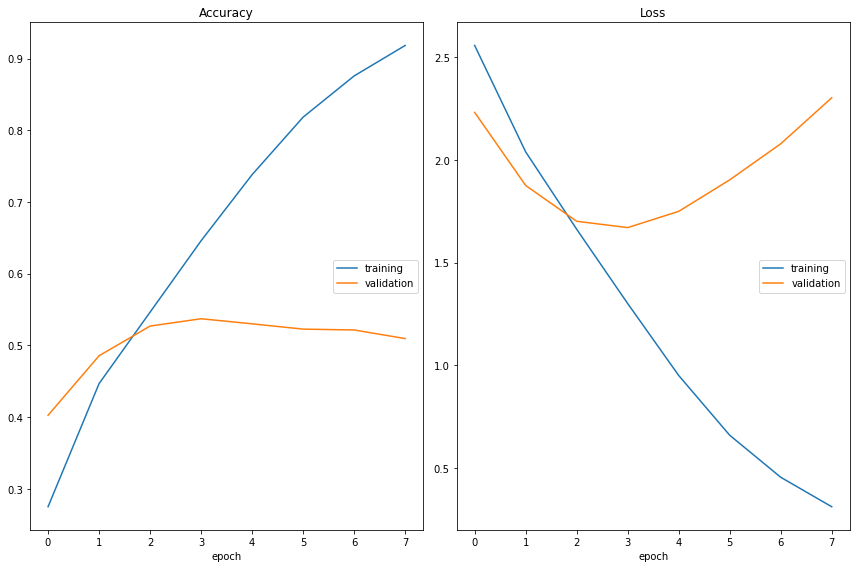

Accuracy
	training         	 (min:    0.275, max:    0.918, cur:    0.918)
	validation       	 (min:    0.402, max:    0.537, cur:    0.509)
Loss
	training         	 (min:    0.312, max:    2.557, cur:    0.312)
	validation       	 (min:    1.671, max:    2.303, cur:    2.303)

Epoch 00008: val_acc did not improve from 0.53712


In [27]:
BATCH_SIZE = 512
NUM_EPOCHS = 8

history = model.fit(x_train,
                    y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[PlotLossesCallback(), checkpoint])

**Построим графики обучения модели**

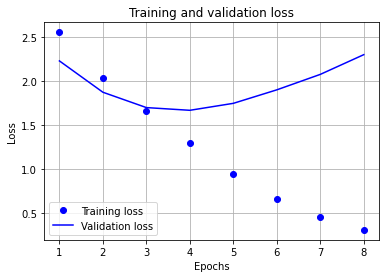

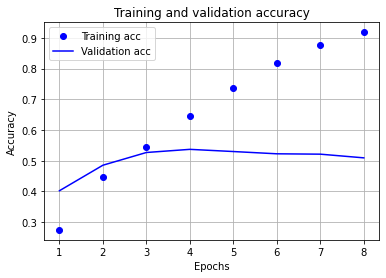

In [28]:
epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

**Загрузим сохранённые веса и проверим модель на тестовых данных**

In [29]:
model.load_weights(str(cpt_path))
results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1694/1694 [==============================] - 41s 19ms/step - loss: 1.6741 - acc: 0.5366
Test loss: 1.6741
Test accuracy: 53.66 %


**Сделаем predict на примере из тестовых данных**

In [118]:
genre_code = {v:k for k, v in zip(test_df['Genre'].unique(), test_df['Genre_cat'].unique())}

In [146]:
sample_number = 45
sample = np.array(test_df['Vectorized_description'][sample_number])
sample.resize(250, refcheck=False)
predict = model.predict(sample[None, ...])
predicted_label = np.argmax(predict, axis = -1)
print(f"Предсказанный жанр -{genre_code[int(predicted_label)]}, истиный жанр -{genre_code[test_df['Genre_cat'][sample_number]]}")

Предсказанный жанр - documentary , истиный жанр - documentary 
